Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [19]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

%matplotlib notebook
import matplotlib

import matplotlib.pyplot as plt

import math

First reload the data we generated in `1_notmnist.ipynb`.

In [20]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [21]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [22]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# I want to re-randomize the inputs, I am not convinced they are shuffled well
total_dataset = np.concatenate((train_dataset, valid_dataset, test_dataset), axis=0)
total_labels = np.concatenate((train_labels, valid_labels, test_labels), axis=0)
total_dataset, total_labels = randomize(total_dataset, total_labels)
train_start = 0
valid_start = train_dataset.shape[0]
test_start = valid_start + valid_dataset.shape[0]

train_dataset = total_dataset[train_start:valid_start, :]
train_labels = total_labels[train_start:valid_start] 

valid_dataset = total_dataset[valid_start:test_start, :]
valid_labels = total_labels[valid_start:test_start] 

test_dataset = total_dataset[test_start:, :]
test_labels = total_labels[test_start:] 
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


----
Base implementation for reference
----

In [23]:
hidden_layer_width = 1024
batch_size = 32
num_epochs = 3

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  w1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, hidden_layer_width]))
  b1 = tf.Variable(tf.zeros([hidden_layer_width]))
    
  w_final = tf.Variable(
      tf.truncated_normal([hidden_layer_width, num_labels]))
  b_final = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  layer1_activations = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
  final_activations = tf.matmul(layer1_activations, w_final) + b_final
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=final_activations))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(final_activations)
  valid_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w_final) + b_final)
  test_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w_final) + b_final)

num_steps = train_dataset.shape[0] // batch_size

for epoch in range(num_epochs):
    train_dataset, train_labels = randomize(train_dataset, train_labels)

    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("==========", "Epoch ", epoch, "==========")
  
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step == num_steps - 1):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
  
      if (epoch == num_epochs - 1) :
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

========== Epoch  0 ==========
Minibatch loss at step 6249: 4.469460
Minibatch accuracy: 81.2%
Validation accuracy: 79.2%
========== Epoch  1 ==========
Minibatch loss at step 6249: 9.242760
Minibatch accuracy: 65.6%
Validation accuracy: 82.0%
========== Epoch  2 ==========
Minibatch loss at step 6249: 10.132338
Minibatch accuracy: 84.4%
Validation accuracy: 82.5%
Test accuracy: 82.3%


---
Problem 1 (L2 Regularization)
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [24]:
hidden_layer_width = 1024
batch_size = 32
num_epochs = 3
beta = 0.005 # l2 regularization param

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  w1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, hidden_layer_width]))
  b1 = tf.Variable(tf.zeros([hidden_layer_width]))
    
  w_final = tf.Variable(
      tf.truncated_normal([hidden_layer_width, num_labels]))
  b_final = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  layer1_activations = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
  final_activations = tf.matmul(layer1_activations, w_final) + b_final
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=final_activations)) + beta * tf.nn.l2_loss(w1)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(final_activations)
  valid_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w_final) + b_final)
  test_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w_final) + b_final)

num_steps = train_dataset.shape[0] // batch_size

for epoch in range(num_epochs):
    train_dataset, train_labels = randomize(train_dataset, train_labels)

    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("==========", "Epoch ", epoch, "==========")
  
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step == num_steps - 1):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
  
      if (epoch == num_epochs - 1) :
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

========== Epoch  0 ==========
Minibatch loss at step 6249: 3.593288
Minibatch accuracy: 84.4%
Validation accuracy: 85.8%
========== Epoch  1 ==========
Minibatch loss at step 6249: 3.853190
Minibatch accuracy: 78.1%
Validation accuracy: 86.0%
========== Epoch  2 ==========
Minibatch loss at step 6249: 3.934860
Minibatch accuracy: 78.1%
Validation accuracy: 86.2%
Test accuracy: 85.9%


---
Problem 2 (Overfitting)
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

Answer: Accuracy drops from ~85% --> ~65%

---

In [25]:
hidden_layer_width = 1024
batch_size = 32
num_epochs = 3
beta = 0.005 # l2 regularization param

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  w1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, hidden_layer_width]))
  b1 = tf.Variable(tf.zeros([hidden_layer_width]))
    
  w_final = tf.Variable(
      tf.truncated_normal([hidden_layer_width, num_labels]))
  b_final = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  layer1_activations = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
  final_activations = tf.matmul(layer1_activations, w_final) + b_final
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=final_activations)) + beta * tf.nn.l2_loss(w1)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(final_activations)
  valid_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w_final) + b_final)
  test_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w_final) + b_final)

num_steps = train_dataset.shape[0] // batch_size

for epoch in range(num_epochs):
    # train_dataset, train_labels = randomize(train_dataset, train_labels)

    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("==========", "Epoch ", epoch, "==========")
  
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Only use 10 batches
        offset = (step * batch_size) % (5 * batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step == num_steps - 1):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
  
      if (epoch == num_epochs - 1) :
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

========== Epoch  0 ==========
Minibatch loss at step 6249: 2.994679
Minibatch accuracy: 100.0%
Validation accuracy: 65.9%
========== Epoch  1 ==========
Minibatch loss at step 6249: 2.994991
Minibatch accuracy: 100.0%
Validation accuracy: 64.6%
========== Epoch  2 ==========
Minibatch loss at step 6249: 2.991493
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Test accuracy: 65.7%


---
Problem 3 (Dropout)
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

Answer: We go from ~65% accuracy to more around 74%

---

Overfit + Dropout
----


In [26]:
hidden_layer_width = 1024
batch_size = 32
num_epochs = 3
beta = 0.005 # l2 regularization param
learn_rate = 0.1
dropout_percent = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  w1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, hidden_layer_width]))
  b1 = tf.Variable(tf.zeros([hidden_layer_width]))
    
  w_final = tf.Variable(
      tf.truncated_normal([hidden_layer_width, num_labels]))
  b_final = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  layer1_activations = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1), 1.0 - dropout_percent)
  final_activations = tf.matmul(layer1_activations, w_final) + b_final
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=final_activations)) + beta * tf.nn.l2_loss(w1)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(learn_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(final_activations)
  valid_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w_final) + b_final)
  test_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w_final) + b_final)
    
num_steps = train_dataset.shape[0] // batch_size

for epoch in range(num_epochs):
    train_dataset, train_labels = randomize(train_dataset, train_labels)

    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("==========", "Epoch ", epoch, "==========")
  
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = (step * batch_size) % (10 * batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step == num_steps - 1):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
  
      if (epoch == num_epochs - 1) :
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

========== Epoch  0 ==========
Minibatch loss at step 6249: 5.484126
Minibatch accuracy: 96.9%
Validation accuracy: 72.5%
========== Epoch  1 ==========
Minibatch loss at step 6249: 4.219392
Minibatch accuracy: 100.0%
Validation accuracy: 75.7%
========== Epoch  2 ==========
Minibatch loss at step 6249: 4.082470
Minibatch accuracy: 100.0%
Validation accuracy: 76.1%
Test accuracy: 75.5%


Good pipeline + dropout
----


In [27]:
hidden_layer_width = 1024
batch_size = 32
num_epochs = 3
beta = 0.005 # l2 regularization param
learn_rate = 0.1
dropout_percent = 0.3

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  w1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, hidden_layer_width]))
  b1 = tf.Variable(tf.zeros([hidden_layer_width]))
    
  w_final = tf.Variable(
      tf.truncated_normal([hidden_layer_width, num_labels]))
  b_final = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  layer1_activations = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1), 1.0 - dropout_percent)
  final_activations = tf.matmul(layer1_activations, w_final) + b_final
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=final_activations)) + beta * tf.nn.l2_loss(w1)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(learn_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(final_activations)
  valid_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w_final) + b_final)
  test_prediction = tf.nn.softmax(
      tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w_final) + b_final)
    
num_steps = train_dataset.shape[0] // batch_size

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for epoch in range(num_epochs):
      train_dataset, train_labels = randomize(train_dataset, train_labels)

      print("==========", "Epoch ", epoch, "==========")
  
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step == num_steps - 1):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
  
      if (epoch == num_epochs - 1) :
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

========== Epoch  0 ==========
Minibatch loss at step 6249: 3.345323
Minibatch accuracy: 93.8%
Validation accuracy: 85.9%
========== Epoch  1 ==========
Minibatch loss at step 6249: 1.021154
Minibatch accuracy: 75.0%
Validation accuracy: 85.5%
========== Epoch  2 ==========
Minibatch loss at step 6249: 0.373631
Minibatch accuracy: 90.6%
Validation accuracy: 86.5%
Test accuracy: 85.8%


---
Problem 4 (Get Gud)
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
Best Impl so far
 ---


In [28]:
hidden_layer_width = [2048, 1024]
batch_size = 128
num_epochs = 10
beta = 0.0005 # l2 regularization param
start_learn_rate = 0.2 # Seems to be about the max stable number
end_learn_rate = 0.01
dropout_percent = 0.0

# Derived parameters
num_steps = train_dataset.shape[0] // batch_size
learn_rate_n_steps = num_steps * num_epochs
learn_rate_decay = end_learn_rate / start_learn_rate

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_batch_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_batch_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  
  tf_train_dataset = tf.constant(train_dataset)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  
  global_step = tf.Variable(0, trainable=False)  
  w1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, hidden_layer_width[0]], stddev=np.sqrt(2.0 / hidden_layer_width[0])))
  b1 = tf.Variable(tf.zeros([hidden_layer_width[0]]))

  w2 = tf.Variable(
      tf.truncated_normal([hidden_layer_width[0], hidden_layer_width[1]], stddev=np.sqrt(2.0 / hidden_layer_width[1])))
  b2 = tf.Variable(tf.zeros([hidden_layer_width[1]]))
    
  w_final = tf.Variable(
      tf.truncated_normal([hidden_layer_width[1], num_labels], stddev=np.sqrt(2.0 / num_labels)))
  b_final = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  layer1_activations = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_batch_dataset, w1) + b1), 1.0 - dropout_percent)
  layer2_activations = tf.nn.dropout(tf.nn.relu(tf.matmul(layer1_activations, w2) + b2), 1.0 - dropout_percent)
  final_activations = tf.matmul(layer2_activations, w_final) + b_final
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_batch_labels, logits=final_activations))
  loss = loss + beta * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(b2))
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  learn_rate = tf.train.exponential_decay(start_learn_rate, global_step, learn_rate_n_steps, learn_rate_decay)
  optimizer = tf.train.GradientDescentOptimizer(learn_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  batch_prediction = tf.nn.softmax(final_activations)
  
  valid_prediction_l1 = tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1)
  valid_prediction_l2 = tf.nn.relu(tf.matmul(valid_prediction_l1, w2) + b2)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_prediction_l2, w_final) + b_final)

  test_prediction_l1 = tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1)
  test_prediction_l2 = tf.nn.relu(tf.matmul(test_prediction_l1, w2) + b2)
  test_prediction = tf.nn.softmax(tf.matmul(test_prediction_l2, w_final) + b_final)
    
  train_prediction_l1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
  train_prediction_l2 = tf.nn.relu(tf.matmul(train_prediction_l1, w2) + b2)
  train_prediction = tf.nn.softmax(tf.matmul(train_prediction_l2, w_final) + b_final)

original_train_labels = train_labels

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for epoch in range(num_epochs):
      train_dataset, train_labels = randomize(train_dataset, train_labels)
      print("==========", "Epoch ", epoch, "==========")
  
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_batch_dataset : batch_data, tf_batch_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, batch_prediction], feed_dict=feed_dict)
        if (step == num_steps - 1):
          print("\\\\\\\\\\\\")
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
          valid_prediction.eval(), valid_labels))
          print("Training set accuracy: %.1f%%" % accuracy(train_prediction.eval(), original_train_labels))
          print("////////////")
  
      if (epoch == num_epochs - 1) :
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

========== Epoch  0 ==========
\\\\\\
Minibatch loss at step 1561: 1.363245
Minibatch accuracy: 89.1%
Validation accuracy: 88.7%
Training set accuracy: 90.0%
////////////
========== Epoch  1 ==========
\\\\\\
Minibatch loss at step 1561: 1.142367
Minibatch accuracy: 91.4%
Validation accuracy: 90.2%
Training set accuracy: 92.0%
////////////
========== Epoch  2 ==========
\\\\\\
Minibatch loss at step 1561: 0.975863
Minibatch accuracy: 93.0%
Validation accuracy: 90.5%
Training set accuracy: 93.3%
////////////
========== Epoch  3 ==========
\\\\\\
Minibatch loss at step 1561: 0.946627
Minibatch accuracy: 93.0%
Validation accuracy: 91.2%
Training set accuracy: 94.3%
////////////
========== Epoch  4 ==========
\\\\\\
Minibatch loss at step 1561: 0.727329
Minibatch accuracy: 96.1%
Validation accuracy: 91.3%
Training set accuracy: 95.0%
////////////
========== Epoch  5 ==========
\\\\\\
Minibatch loss at step 1561: 0.815085
Minibatch accuracy: 93.8%
Validation accuracy: 91.4%
Training set acc

<IPython.core.display.Javascript object>


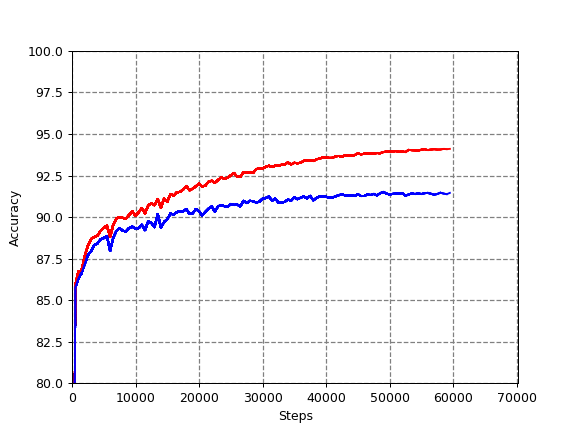

Test accuracy: 91.0%


In [29]:
hidden_layer_width = [2048, 1024, 512, 512]
batch_size = 128
num_epochs = 30
beta = 0.005  #0.005 # l2 regularization param
start_learn_rate = 0.1 # Seems to be about the max stable number
end_learn_rate = 0.001
dropout_percent = [0.3, 0.2, 0.2, 0.1]

# Derived parameters
num_steps = train_dataset.shape[0] // batch_size
learn_rate_n_steps = num_steps * num_epochs
learn_rate_decay = end_learn_rate / start_learn_rate

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_batch_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_batch_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  
  tf_train_dataset = tf.constant(train_dataset)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  
  global_step = tf.Variable(0, trainable=False)  
  w1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, hidden_layer_width[0]], stddev=np.sqrt(2.0 / hidden_layer_width[0])))
  b1 = tf.Variable(tf.zeros([hidden_layer_width[0]]))

  w2 = tf.Variable(
      tf.truncated_normal([hidden_layer_width[0], hidden_layer_width[1]], stddev=np.sqrt(2.0 / hidden_layer_width[1])))
  b2 = tf.Variable(tf.zeros([hidden_layer_width[1]]))

  w3 = tf.Variable(
      tf.truncated_normal([hidden_layer_width[1], hidden_layer_width[2]], stddev=np.sqrt(2.0 / hidden_layer_width[2])))
  b3 = tf.Variable(tf.zeros([hidden_layer_width[2]]))

  w4 = tf.Variable(
      tf.truncated_normal([hidden_layer_width[2], hidden_layer_width[3]], stddev=np.sqrt(2.0 / hidden_layer_width[3])))
  b4 = tf.Variable(tf.zeros([hidden_layer_width[3]]))
    
  w_final = tf.Variable(
      tf.truncated_normal([hidden_layer_width[3], num_labels], stddev=np.sqrt(2.0 / num_labels)))
  b_final = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  layer1_activations = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_batch_dataset, w1) + b1), 1.0 - dropout_percent[0])
  layer2_activations = tf.nn.dropout(tf.nn.relu(tf.matmul(layer1_activations, w2) + b2), 1.0 - dropout_percent[1])
  layer3_activations = tf.nn.dropout(tf.nn.relu(tf.matmul(layer2_activations, w3) + b3), 1.0 - dropout_percent[2])
  layer4_activations = tf.nn.dropout(tf.nn.relu(tf.matmul(layer3_activations, w4) + b4), 1.0 - dropout_percent[3])
  final_activations = tf.matmul(layer4_activations, w_final) + b_final
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_batch_labels, logits=final_activations))
  loss = loss + beta * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(b1) + 
                        tf.nn.l2_loss(w2) + tf.nn.l2_loss(b2) + 
                        tf.nn.l2_loss(w3) + tf.nn.l2_loss(b3) + 
                        tf.nn.l2_loss(w4) + tf.nn.l2_loss(b4))
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  learn_rate = tf.train.exponential_decay(start_learn_rate, global_step, learn_rate_n_steps, learn_rate_decay)
  optimizer = tf.train.GradientDescentOptimizer(learn_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  batch_prediction = tf.nn.softmax(final_activations)
  
  valid_prediction_l1 = tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1)
  valid_prediction_l2 = tf.nn.relu(tf.matmul(valid_prediction_l1, w2) + b2)
  valid_prediction_l3 = tf.nn.relu(tf.matmul(valid_prediction_l2, w3) + b3)
  valid_prediction_l4 = tf.nn.relu(tf.matmul(valid_prediction_l3, w4) + b4)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_prediction_l4, w_final) + b_final)

  test_prediction_l1 = tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1)
  test_prediction_l2 = tf.nn.relu(tf.matmul(test_prediction_l1, w2) + b2)
  test_prediction_l3 = tf.nn.relu(tf.matmul(test_prediction_l2, w3) + b3)
  test_prediction_l4 = tf.nn.relu(tf.matmul(test_prediction_l3, w4) + b4)
  test_prediction = tf.nn.softmax(tf.matmul(test_prediction_l4, w_final) + b_final)
    
  train_prediction_l1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
  train_prediction_l2 = tf.nn.relu(tf.matmul(train_prediction_l1, w2) + b2)
  train_prediction_l3 = tf.nn.relu(tf.matmul(train_prediction_l2, w3) + b3)
  train_prediction_l4 = tf.nn.relu(tf.matmul(train_prediction_l3, w4) + b4)
  train_prediction = tf.nn.softmax(tf.matmul(train_prediction_l4, w_final) + b_final)

original_train_labels = train_labels
record_data_period = 500
next_plot_index = 0
validation_plot_data = []
training_plot_data   = []
minibatch_plot_data  = []

fig, plot = plt.subplots(1,1)
plot.set_xlabel('Steps')
plot.set_ylabel('Accuracy')
plot.set_xlim(0, num_epochs * num_steps * 1.5)
plot.set_ylim(80,100)
plot.grid(color='gray', linestyle='--', linewidth=1)
fig.canvas.draw()
# plot.plot(np.arange(next_plot_index) * record_data_period, np.arange(next_plot_index) * 100)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for epoch in range(num_epochs):
      train_dataset, train_labels = randomize(train_dataset, train_labels)
      # print("==========", "Epoch ", epoch, "==========")
  
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_batch_dataset : batch_data, tf_batch_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, batch_prediction], feed_dict=feed_dict)
        if (step % record_data_period == 0):
          if math.isnan(l):
            print("Loss is NAN, search diverged")
          
          # Update the plot
          validation_plot_data.append(accuracy(valid_prediction.eval(), valid_labels))
          training_plot_data.append(accuracy(train_prediction.eval(), original_train_labels))
          minibatch_plot_data.append(accuracy(predictions, batch_labels))
          next_plot_index += 1
          plot.plot(np.arange(next_plot_index) * record_data_period, training_plot_data, 'red')
          # plot.plot(np.arange(next_plot_index) * record_data_period, minibatch_plot_data, 'orange')
          plot.plot(np.arange(next_plot_index) * record_data_period, validation_plot_data, 'blue')
          plot.set_xlabel("Steps")
          fig.canvas.draw()
          
          
  
      if (epoch == num_epochs - 1) :
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

NOTE
----

I attempted to match the "best" deep impl desribed in the note at the beginning of part 4 [repeated here](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595), but then I realized that they forgot to randomize their dataset just like I did in the begining :p so they really get ~93 (valid dataset). After realizing this I am okay with 91.1% and am calling it a day to move on with the course.